# FNO for virtual damage sensor

In [1]:
# packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path
from nopkit.data import load_damage_sensor_dataset
from nopkit.mask import MaskGenerator
from nopkit.plot import data_image, pred_image

device = 'cpu'

c:\workspace\no_playground\neuralop-playground\nopkit_pkg\nopkit\mask.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.masks = torch.tensor(mask_list, dtype=torch.float32) # (n_masks, height, width)


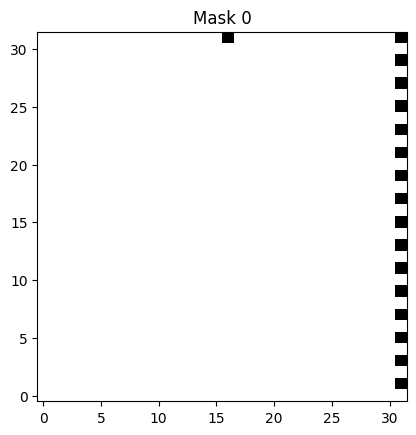

In [2]:
# Using Saikat's mask
gen = MaskGenerator(grid_shape=(32, 32))

pos = [
    (31, 16),
    (1, 31), (3, 31), (5, 31), (7, 31), (9, 31), (11, 31), (13, 31), (15, 31),
    (17, 31), (19, 31), (21, 31), (23, 31), (25, 31), (27, 31), (29, 31), (31, 31)
]
masks = gen.generate_from_positions([pos])
gen.plot()
gen.save("../data/damage_sensor/mask_saikat.pt")

In [25]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    masks_path=data_dir / "mask_saikat.pt",
    n_train=450,
    batch_size=10,
    test_batch_sizes=[10],
    test_resolutions=[32],
    encode_input=True,
    encode_output=False,
    encoding="channel-wise",
    channel_dim=1,
)
data_processor = data_processor.to(device)

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\mask_saikat.pt,	(torch.Size([1, 32, 32]))
Loading total samples: 500, total masks: 1
Loading train db: 450 samples, test db: 50 samples
Train input shape: torch.Size([450, 3, 32, 32, 175]), Train output shape: torch.Size([450, 3, 32, 32, 175])
Test input shape: torch.Size([50, 3, 32, 32, 175]), Test output shape: torch.Size([50, 3, 32, 32, 175])


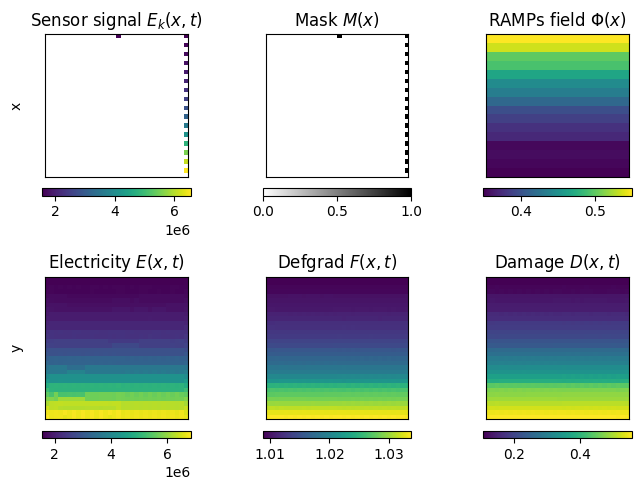

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [26]:
# check data
index = 5
x = train_loader.dataset[index]['x']
y = train_loader.dataset[index]['y']
data_image(x, y, t=174, show_colorbar=True)

In [27]:
# config model
model = FNO(
    n_modes=(16,16,10),
    in_channels=3,
    out_channels=3,
    hidden_channels=64,
    n_layers=4,
    projection_channel_ratio=2,
    positional_embedding = 'grid'
)
model = model.to(device)
data_processor = data_processor.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 50383171 parameters.


In [49]:
epochs=100
learning_rate=1e-3
scheduler_step=100
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2, measure=[1,1,10])
h1loss = H1Loss(d=2, measure=[1,1,10])

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 8, 8, 6]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(6, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64

In [50]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=5,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=train_loader,
    test_loaders=test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=10,
    save_dir="./ckpt/fno3d/"
)

Training on 450 samples
Testing on [50] samples         on resolutions [32].
Raw outputs of shape torch.Size([10, 3, 32, 32, 175])
[0] time=405.02, avg_loss=82.7206, train_err=827.2062
Eval: 32_h1=28.8640, 32_l2=31.9935
[Rank 0]: saved training state to ./ckpt/fno3d/
[5] time=399.50, avg_loss=4.6942, train_err=46.9421
Eval: 32_h1=3.1427, 32_l2=1.4812
[10] time=398.72, avg_loss=3.8981, train_err=38.9809
Eval: 32_h1=2.8344, 32_l2=1.1908
[Rank 0]: saved training state to ./ckpt/fno3d/
[15] time=414.93, avg_loss=3.5580, train_err=35.5801
Eval: 32_h1=2.7639, 32_l2=1.0588
[20] time=402.95, avg_loss=3.5096, train_err=35.0959
Eval: 32_h1=2.3712, 32_l2=0.8573
[Rank 0]: saved training state to ./ckpt/fno3d/
[25] time=391.71, avg_loss=3.0740, train_err=30.7397
Eval: 32_h1=2.4403, 32_l2=0.9048
[30] time=394.86, avg_loss=3.1661, train_err=31.6608
Eval: 32_h1=2.7469, 32_l2=1.1808
[Rank 0]: saved training state to ./ckpt/fno3d/
[35] time=394.67, avg_loss=3.1139, train_err=31.1393
Eval: 32_h1=2.3549, 

{'train_err': 20.238066652086047,
 'avg_loss': 2.0238066652086046,
 'avg_lasso_loss': None,
 'epoch_train_time': 393.4055012999961}

In [51]:
model.save_checkpoint("./model", save_name="fno3d")

In [4]:
# reload
model_reload = FNO.from_checkpoint("./model", save_name="fno3d")

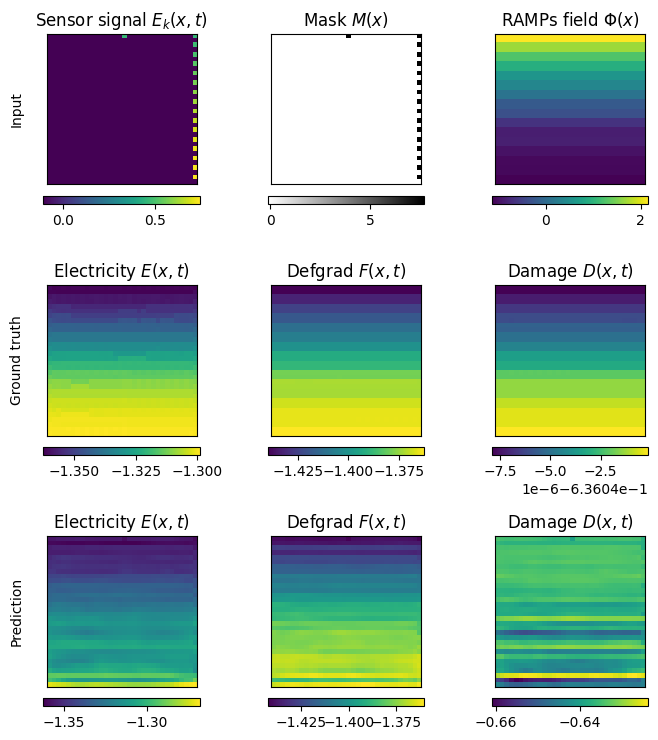

array([[<Axes: title={'center': 'Sensor signal $E_k(x, t)$'}>,
        <Axes: title={'center': 'Mask $M(x)$'}>,
        <Axes: title={'center': 'RAMPs field $\\Phi(x)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>],
       [<Axes: title={'center': 'Electricity $E(x, t)$'}>,
        <Axes: title={'center': 'Defgrad $F(x, t)$'}>,
        <Axes: title={'center': 'Damage $D(x, t)$'}>]], dtype=object)

In [24]:
# plot prediction
model_use = model_reload

test_samples = test_loaders[32].dataset
idx = 10

data = test_samples[idx]
data = data_processor.preprocess(data)

x = data['x']
y = data['y']
out = model_use(x)

out, x = data_processor.postprocess(out, x)
t = 9

pred_image(x.squeeze(0), y.squeeze(0), out.squeeze().detach().numpy(), t=t, show_colorbar=True)